In [1]:
import numpy as np
import pandas as pd
import argparse
import h5py
import pdb
from keras.preprocessing import sequence
import keras
from keras import backend as K
from keras.models import load_model

import tensorflow as tf
from tensorflow import keras 
import datetime, os
from tensorboard import notebook

import matplotlib.pyplot as plt
import seaborn as sns

sess = tf.compat.v1.Session()

init = tf.global_variables_initializer()
sess.run(init)



# loaded_model = load_model('./../CNN_results/model_final.model')

Using TensorFlow backend.


In [2]:
seq_rdic = ['A','I','L','V','F','W','Y','N','C','Q','M','S','T','D','E','R','H','K','G','P','O','U','X','B','Z']
seq_dic = {w: i+1 for i,w in enumerate(seq_rdic)}


def encodeSeq(seq, seq_dic):
    if pd.isnull(seq):
        return [0] 
    else:
        return [seq_dic[aa] for aa in seq]
    
    
def prot_feature_gen_from_str_input(prot_input_str, prot_len = 2500):
    Prot_ID = prot_input_str.split(':')[0]
    Prot_seq = prot_input_str.split(':')[1]
    prot_dataframe = pd.DataFrame({'Protein_ID': Prot_ID, 'Sequence': Prot_seq}, index = [0])
    prot_dataframe.set_index('Protein_ID')
    
    
    prot_dataframe["encoded_sequence"] = prot_dataframe.Sequence.map(lambda a: encodeSeq(a, seq_dic))
    prot_feature = sequence.pad_sequences(prot_dataframe["encoded_sequence"].values, prot_len)
    
    return prot_feature, Prot_ID
    
    
KEGG_compound_read = pd.read_csv('./../CNN_data/Final_test/kegg_compound.csv', index_col = 'Compound_ID')
kegg_df = KEGG_compound_read.reset_index()
    
def mol_feature_gen_from_str_input(mol_str, kegg_id_flag):
	
	if kegg_id_flag == 1:
		KEGG_ID = mol_str
		kegg_id_loc = kegg_df.index[kegg_df.Compound_ID == KEGG_ID][0]
		KEGG_ID_info = kegg_df.loc[kegg_id_loc]
		KEGG_ID_info_df = KEGG_ID_info.to_frame().T.set_index('Compound_ID')
		
		final_return = KEGG_ID_info_df
		final_id = KEGG_ID
		
	else: 
		try:
			mol_ID = mol_str.split(':')[0]
			mol_smiles = mol_str.split(':')[1]
			mol = Chem.MolFromSmiles(mol_smiles)
			fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits=2048)
			fp_list = list(np.array(fp1).astype(float))
			fp_str = list(map(str, fp_list))
			mol_fp = '\t'.join(fp_str) 
			
			mol_dict = {}
			mol_dict['Compound_ID'] = mol_ID
			mol_dict['Smiles'] = mol_smiles
			mol_dict['morgan_fp_r2'] = mol_fp
			
			mol_info_df = pd.DataFrame(mol_dict, index=[0])
			mol_info_df = mol_info_df.set_index('Compound_ID')
			
			final_return = mol_info_df
			final_id = mol_ID
			
		except Exception as error:
			print('Something wrong with molecule input string...' + repr(error)) 
			
	return final_return, final_id
    
    
def act_df_gen_mol_feature(mol_id, prot_id):
	act_df = pd.DataFrame({'Protein_ID':prot_id, 'Compound_ID': mol_id}, index = [0])
	
	return act_df
	
	
def compound_feature_gen_df_input(act_df, comp_df, comp_len = 2048, comp_vec= 'morgan_fp_r2'):
	act_df = pd.merge(act_df, comp_df, left_on='Compound_ID', right_index = True)
	comp_feature = np.stack(act_df[comp_vec].map(lambda fp: fp.split("\t")))
	return comp_feature


def load_modelfile(model_string):
	loaded_model = tf.keras.models.load_model(model_string)
	return loaded_model
	
loaded_model = load_modelfile('./../CNN_results/model_final.model')

def model_prediction(compound_feature, enz_feature):
    prediction_vals = loaded_model.predict([compound_feature, enz_feature])
    
    return prediction_vals[0][0]


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
pstr = "A0A4P8WFA8:MTKRVLVTGGAGFLGSHLCERLLSEGHEVICLDNFGSGRRKNIKEFEDHPSFKVNDRDVRISESLPSVDRIYHLASRASPADFTQFPVNIALANTQGTRRLLDQARACDARMVFASTSEVYGDPKVHPQPETYTGNVNIRGARGCYDESKRFGETLTVAYQRKYDVDARTVRIFNTYGPRMRPDDGRVVPTFVTQALRGDDLTIYGDGEQTRSFCYVDDLIEGLISLMRVDNPEHNVYNIGKENERTIKELAYEVLGLTDTESDIVYEPLPEDDPGQRRPDITRAKTELDWEPKISLREGLEDTITYFDN"
cstr = 'C00149'

pf, pid = prot_feature_gen_from_str_input(pstr)
cf, cid = mol_feature_gen_from_str_input(cstr, 1)
act_dataframe = act_df_gen_mol_feature(cid, pid)

cfeat = compound_feature_gen_df_input(act_dataframe, cf)

In [4]:
loaded_model.predict([cfeat, pf])

array([[0.8907268]], dtype=float32)

In [5]:
prot_input_layer = loaded_model.get_layer('input_2')
embedding_1_layer = loaded_model.get_layer('embedding_1')
spatial_dropout1d_1_layer = loaded_model.get_layer('spatial_dropout1d_1')

mol_input_layer = loaded_model.get_layer('input_1')

conv1d_layer1 = loaded_model.get_layer('conv1d_1')
conv1d_layer2 = loaded_model.get_layer('conv1d_2')
conv1d_layer3 = loaded_model.get_layer('conv1d_3')
conv1d_layer4 = loaded_model.get_layer('conv1d_4')
conv1d_layer5 = loaded_model.get_layer('conv1d_5')

batch_normalization_p_conv_layer1 = loaded_model.get_layer('batch_normalization_3')
batch_normalization_p_conv_layer2 = loaded_model.get_layer('batch_normalization_4')
batch_normalization_p_conv_layer3 = loaded_model.get_layer('batch_normalization_5')
batch_normalization_p_conv_layer4 = loaded_model.get_layer('batch_normalization_6')
batch_normalization_p_conv_layer5 = loaded_model.get_layer('batch_normalization_7')

activation_p_conv_layer1 = loaded_model.get_layer('activation_3')
activation_p_conv_layer2 = loaded_model.get_layer('activation_4')
activation_p_conv_layer3 = loaded_model.get_layer('activation_5')
activation_p_conv_layer4 = loaded_model.get_layer('activation_6')
activation_p_conv_layer5 = loaded_model.get_layer('activation_7')


global_max_pooling1d_layer1 = loaded_model.get_layer('global_max_pooling1d_1')
global_max_pooling1d_layer2 = loaded_model.get_layer('global_max_pooling1d_2')
global_max_pooling1d_layer3 = loaded_model.get_layer('global_max_pooling1d_3')
global_max_pooling1d_layer4 = loaded_model.get_layer('global_max_pooling1d_4')
global_max_pooling1d_layer5 = loaded_model.get_layer('global_max_pooling1d_5')

concatenate_p_layers = loaded_model.get_layer('concatenate_1')
dense_layer_3 = loaded_model.get_layer('dense_3')
batch_normalization_p_layer8 = loaded_model.get_layer('batch_normalization_8')
activation_p_conv_layer8 = loaded_model.get_layer('activation_8')
dropout_p_layer = loaded_model.get_layer('dropout_3')



dense_layer_1_mol = loaded_model.get_layer('dense_1')
batch_normalization_c_layer1 = loaded_model.get_layer('batch_normalization_1')
activation_c_layer1 = loaded_model.get_layer('activation_1')
dropout_c_layer1 = loaded_model.get_layer('dropout_1')

dense_layer_2 = loaded_model.get_layer('dense_2')
batch_normalization_c_layer2 = loaded_model.get_layer('batch_normalization_2')
activation_c_layer2 = loaded_model.get_layer('activation_2')
dropout_c_layer2 = loaded_model.get_layer('dropout_2')


concatenate_layers_final = loaded_model.get_layer('concatenate_2')
dense_layer_final = loaded_model.get_layer('dense_4')
batch_normalization_layer_final = loaded_model.get_layer('batch_normalization_9')
activation_layer_final = loaded_model.get_layer('activation_9')
dense_layer_final_5 = loaded_model.get_layer('dense_5')
lambda_layer = loaded_model.get_layer('lambda_1')

In [6]:
model_prot_input_layer = tf.keras.models.Model([loaded_model.inputs],[prot_input_layer.output, loaded_model.output])
model_embedding_layer_1 = tf.keras.models.Model([loaded_model.inputs],[embedding_1_layer.output, loaded_model.output])
model_spatial_dropout1d_1_layer = tf.keras.models.Model([loaded_model.inputs],[ spatial_dropout1d_1_layer.output, loaded_model.output])

model_mol_input_layer = tf.keras.models.Model([loaded_model.inputs],[mol_input_layer.output, loaded_model.output])

model_conv1d_layer1 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer1.output, loaded_model.output])
model_conv1d_layer2 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer2.output, loaded_model.output])
model_conv1d_layer3 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer3.output, loaded_model.output])
model_conv1d_layer4 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer4.output, loaded_model.output])
model_conv1d_layer5 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer5.output, loaded_model.output])

model_batch_normalization_p_conv_layer1 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer1.output, loaded_model.output])
model_batch_normalization_p_conv_layer2 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer2.output, loaded_model.output])
model_batch_normalization_p_conv_layer3 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer3.output, loaded_model.output])
model_batch_normalization_p_conv_layer4 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer4.output, loaded_model.output])
model_batch_normalization_p_conv_layer5 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer5.output, loaded_model.output])

model_activation_p_conv_layer1 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer1.output, loaded_model.output])
model_activation_p_conv_layer2 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer2.output, loaded_model.output])
model_activation_p_conv_layer3 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer3.output, loaded_model.output])
model_activation_p_conv_layer4 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer4.output, loaded_model.output])
model_activation_p_conv_layer5 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer5.output, loaded_model.output])

model_global_max_pooling1d_layer1 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer1.output, loaded_model.output])
model_global_max_pooling1d_layer2 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer2.output, loaded_model.output])
model_global_max_pooling1d_layer3 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer3.output, loaded_model.output])
model_global_max_pooling1d_layer4 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer4.output, loaded_model.output])
model_global_max_pooling1d_layer5 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer5.output, loaded_model.output])


model_concatenate_p_layers = tf.keras.models.Model([loaded_model.inputs],[concatenate_p_layers.output, loaded_model.output])
model_dense_layer_3 = tf.keras.models.Model([loaded_model.inputs],[dense_layer_3.output, loaded_model.output])
model_batch_normalization_p_layer8 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_layer8.output, loaded_model.output])
model_activation_p_conv_layer8 =  tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer8.output, loaded_model.output])
model_dropout_p_layer = tf.keras.models.Model([loaded_model.inputs],[dropout_p_layer.output, loaded_model.output])


model_dense_layer_1_mol = tf.keras.models.Model([loaded_model.inputs],[dense_layer_1_mol.output, loaded_model.output])
model_batch_normalization_c_layer1 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_c_layer1.output, loaded_model.output])
model_activation_c_layer1 = tf.keras.models.Model([loaded_model.inputs],[activation_c_layer1.output, loaded_model.output])
model_dropout_c_layer1 = tf.keras.models.Model([loaded_model.inputs],[dropout_c_layer1.output, loaded_model.output])

model_dense_layer_2 = tf.keras.models.Model([loaded_model.inputs],[dense_layer_2.output, loaded_model.output])
model_batch_normalization_c_layer2 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_c_layer2.output, loaded_model.output])
model_activation_c_layer2 = tf.keras.models.Model([loaded_model.inputs],[activation_c_layer2.output, loaded_model.output])
model_dropout_c_layer2 = tf.keras.models.Model([loaded_model.inputs],[dropout_c_layer2.output, loaded_model.output])

model_concatenate_layers_final = tf.keras.models.Model([loaded_model.inputs],[concatenate_layers_final.output, loaded_model.output])
model_dense_layer_final = tf.keras.models.Model([loaded_model.inputs],[dense_layer_final.output, loaded_model.output])
model_batch_normalization_layer_final = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_layer_final.output, loaded_model.output])
model_activation_layer_final = tf.keras.models.Model([loaded_model.inputs],[activation_layer_final.output, loaded_model.output])
model_dense_layer_final_5 = tf.keras.models.Model([loaded_model.inputs],[dense_layer_final_5.output, loaded_model.output])
model_lambda_layer = tf.keras.models.Model([loaded_model.inputs],[lambda_layer.output, loaded_model.output])

In [7]:
layer_out_p, preds_0_p = model_prot_input_layer([cfeat, pf])
layer_out_m, preds_0_m = model_mol_input_layer([cfeat, pf])

layer_out_p_in = layer_out_p.eval(session = sess)
layer_out_m_in = layer_out_m.eval(session = sess)



In [35]:
model_conv1d_layer1([cfeat, pf])

[<tf.Tensor 'model_4_2/conv1d_1/BiasAdd:0' shape=(1, 2500, 128) dtype=float32>,
 <tf.Tensor 'model_4_2/lambda_1/truediv:0' shape=(1, 1) dtype=float32>]

In [25]:
layer_out_p.eval(session=sess)

array([[ 0,  0,  0, ...,  5, 14,  8]])

In [30]:
emb_l_out, preds_0_emb = model_embedding_layer_1([cfeat, pf])

In [34]:
emb_l_out.eval(session=sess)

NotFoundError: Container localhost does not exist. (Could not find resource: localhost/embedding_1/embeddings)
	 [[node model_1_2/embedding_1/embedding_lookup (defined at C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'model_1_2/embedding_1/embedding_lookup':
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-f2c3c317e253>", line 1, in <module>
    emb_l_out, preds_0_emb = model_embedding_layer_1([cfeat, pf])
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 898, in __call__
    outputs = self.call(cast_inputs, *args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\network.py", line 695, in call
    return self._run_internal_graph(inputs, training=training, mask=mask)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\network.py", line 844, in _run_internal_graph
    output_tensors = layer(computed_tensors, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 854, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\layers\embeddings.py", line 183, in call
    out = embedding_ops.embedding_lookup(self.embeddings, inputs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\embedding_ops.py", line 317, in embedding_lookup
    transform_fn=None)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\embedding_ops.py", line 135, in _embedding_lookup_and_transform
    array_ops.gather(params[0], ids, name=name), ids, max_norm)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\util\dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\array_ops.py", line 3953, in gather
    return params.sparse_read(indices, name=name)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 640, in sparse_read
    self._handle, indices, dtype=self._dtype, name=name)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\gen_resource_variable_ops.py", line 682, in resource_gather
    _result = _op.outputs[:]
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [28]:
emb_l_out.eval(session=sess)

NotFoundError: Container localhost does not exist. (Could not find resource: localhost/embedding_1/embeddings)
	 [[node model_1_1/embedding_1/embedding_lookup (defined at C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'model_1_1/embedding_1/embedding_lookup':
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "C:\Users\vuu10\AppData\Local\Continuum\anaconda3\envs\env_py3_tr1\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-f2c3c317e253>", line 1, in <module>
    emb_l_out, preds_0_emb = model_embedding_layer_1([cfeat, pf])
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 898, in __call__
    outputs = self.call(cast_inputs, *args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\network.py", line 695, in call
    return self._run_internal_graph(inputs, training=training, mask=mask)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\network.py", line 844, in _run_internal_graph
    output_tensors = layer(computed_tensors, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 854, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\layers\embeddings.py", line 183, in call
    out = embedding_ops.embedding_lookup(self.embeddings, inputs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\embedding_ops.py", line 317, in embedding_lookup
    transform_fn=None)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\embedding_ops.py", line 135, in _embedding_lookup_and_transform
    array_ops.gather(params[0], ids, name=name), ids, max_norm)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\util\dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\array_ops.py", line 3953, in gather
    return params.sparse_read(indices, name=name)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 640, in sparse_read
    self._handle, indices, dtype=self._dtype, name=name)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\gen_resource_variable_ops.py", line 682, in resource_gather
    _result = _op.outputs[:]
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Users\vuu10\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [13]:
lol, plol = model_conv1d_layer1([cfeat, pf])

In [14]:
lol

<tf.Tensor 'model_4/conv1d_1/BiasAdd:0' shape=(1, 2500, 128) dtype=float32>

In [ ]:
lol.eval(session=sess)

In [62]:
def grad_cam(layer_name, data):
    grad_model = tf.keras.models.Model(
        [loaded_model.inputs], [loaded_model.get_layer(layer_name).output, loaded_model.output]
    )
    last_conv_layer_output, preds = grad_model(data)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tf.gradients(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = tf.expand_dims(heatmap,0)
    return heatmap

In [50]:
concatenate_layers_final

In [17]:
data = [cfeat, pf]

In [18]:
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = model_conv1d_layer1(data)
    pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

grads = tf.gradients(class_channel, last_conv_layer_output)


In [19]:
pooled_grads = tf.reduce_mean(grads, axis=(0))

last_conv_layer_output = last_conv_layer_output[0]

heatmap = last_conv_layer_output * pooled_grads
heatmap = tf.reduce_mean(heatmap, axis=(1))

In [20]:
heatmap

<tf.Tensor 'Mean_1:0' shape=(1, 128) dtype=float32>

In [21]:
lh = tf.expand_dims(heatmap,0)
lh

<tf.Tensor 'ExpandDims:0' shape=(1, 1, 128) dtype=float32>

NotImplementedError: Cannot convert a symbolic Tensor (Mean_1:0) to a numpy array.

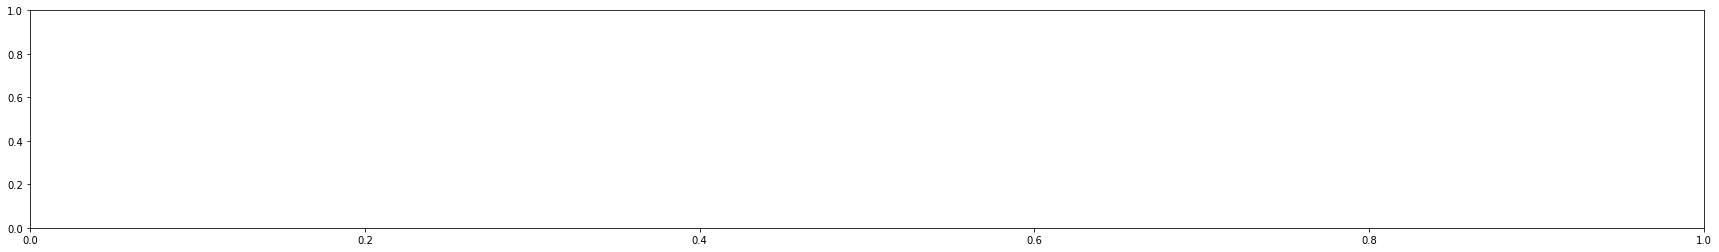

In [23]:
plt.figure(figsize=(30,4))
plt.imshow(heatmap,cmap='Reds', aspect="auto", interpolation='nearest', alpha=0.5)
plt.plot(i,'k')
plt.colorbar()
plt.show()

In [ ]:

pooled_grads = tf.reduce_mean(grads, axis=(0))

last_conv_layer_output = last_conv_layer_output[0]

heatmap = last_conv_layer_output * pooled_grads
heatmap = tf.reduce_mean(heatmap, axis=(1))
heatmap = tf.expand_dims(heatmap,0)

In [70]:
heatmap

<tf.Tensor 'ExpandDims_7:0' shape=(1, 1, 128) dtype=float32>

NotImplementedError: Cannot convert a symbolic Tensor (ExpandDims_8:0) to a numpy array.

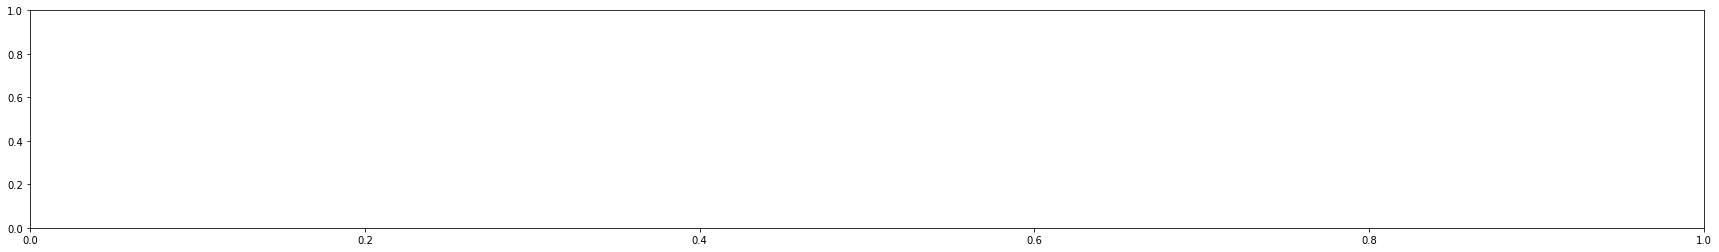

In [69]:
data = [cfeat, pf]
heatmap = grad_cam('conv1d_1',data)

plt.figure(figsize=(30,4))
plt.imshow(tf.expand_dims(heatmap,axis=2),cmap='Reds', aspect="auto", interpolation='nearest', alpha=0.5)
plt.plot(i,'k')
plt.colorbar()
plt.show()

In [ ]:
loaded_model.get_layer('')

In [98]:
wt = loaded_model.weights

In [27]:
x1, x2 = model_embedding_layer_1([cfeat, pf])

In [26]:
xx, pr = model_concatenate_layers_final([cfeat, pf])

In [28]:
with tf.GradientTape() as tape:
    xx, pr = model_concatenate_layers_final([cfeat, pf])
    pred_index = tf.argmax(pr[0])
    class_channel = pr[:, pred_index]

In [29]:
grads = tf.gradients(class_channel, xx)

In [30]:
pooled_grads = tf.reduce_mean(grads, axis=(0))

In [31]:
lco  = xx[0]

In [32]:
pooled_grads

<tf.Tensor 'Mean:0' shape=(1, 256) dtype=float32>

In [33]:
hm =  lco*pooled_grads

In [ ]:
hm[1]

In [42]:
hm = tf.reduce_mean(hm)


In [44]:
hm  =  tf.expand_dims(hm, 0)

In [46]:
data = [cfeat, pf]

In [47]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(tf.expand_dims(hm, axis= 2), cmaps = 'Reds', aspect='auto', interpolation='nearest', alpha=0.5)


In [114]:
weight_embedding_layer = model_weights[0]

In [140]:
loaded_model.predict([cfeat, pf])


array([[0.8907268]], dtype=float32)

In [73]:
model_emb = tf.keras.models.Model([model_prot_input_layer.input], [embedding_1_layer.output])

In [ ]:
model_emb([cfeat, pf]).eval(session=sess)

In [49]:
lol_nozeros = np.trim_zeros(layer_out_p_in[0])
lol_nozeros = lol_nozeros.reshape(1, len(lol_nozeros))

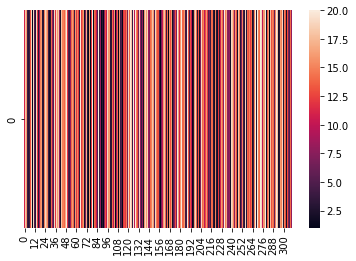

In [50]:
hm = sns.heatmap(lol_nozeros)

In [ ]:
sns.heatmap(layer_out_m_in[0].reshape(2048, 1))

In [63]:
d5_out, pds = mdel([cfeat, pf])

In [64]:
with tf.GradientTape() as tape: 
    lpo, prd = mdel([cfeat, pf])
    p_ix = tf.argmax(prd[0])
    cls_chnl = prd[:, p_ix]

In [104]:
emb_lay_out, emb_pred = model_embedding_layer_1([cfeat, pf])

In [115]:
sess = tf.InteractiveSession()

In [117]:
lol = layer_out.eval()

In [ ]:
preds.eval()

In [133]:
lol_nozeros = np.trim_zeros(lol[0])

In [ ]:
model_embedding_layer_1.predict([cfeat, pf])

In [ ]:
with tf.Session() as sess:
    print(emb_lay_out.eval())

In [137]:
lol_nozeros = lol_nozeros.reshape(1, len(lol_nozeros))

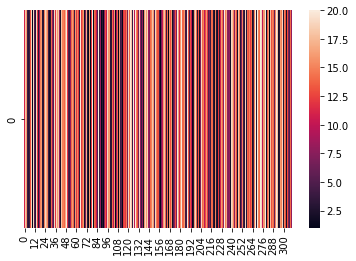

In [148]:
import tensorboard
tensorboard.__version__

from datetime import datetime
from packaging import version

In [116]:
from keras import backend as K


In [123]:
loaded_model.input

[<tf.Tensor 'input_1_1:0' shape=(?, 2048) dtype=float32>,
 <tf.Tensor 'input_2_1:0' shape=(?, 2500) dtype=float32>]

In [146]:
pin = tf.convert_to_tensor(pf)
cin = tf.convert_to_tensor(cfeature)

In [147]:
input_t1 = [cin, pin]

In [150]:
fu = K.function([loaded_model.get_layer(index=0).input], prot_input_layer.output)

In [166]:
cstring = 'C00149:O[C@@H](CC([O-])=O)C([O-])=O'

In [211]:
xx, xid = mol_feature_gen_from_str_input(cstring, 0)

In [168]:
mol_str = cstring

In [170]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions as Reactions

In [212]:
xx

,Smiles,morgan_fp_r2
Compound_ID,,
C00149,O[C@@H](CC([O-])=O)C([O-])=O,0.0\t1.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0...


In [213]:
xid

'C00149'

In [214]:
af = act_df_gen_mol_feature(xid, pid)
af

,Protein_ID,Compound_ID
0,A0A4P8WFA8,C00149


In [215]:
xf = compound_feature_gen_df_input(af, xx)


In [216]:
xf

array([['0.0', '1.0', '0.0', ..., '0.0', '0.0', '0.0']], dtype='<U3')

,Protein_ID,Compound_ID
0,A0A4P8WFA8,C00149


In [206]:
xx

,Smiles,morgan_fp_r2
Compound_ID,,
C00149,O[C@@H](CC([O-])=O)C([O-])=O,0.0\t1.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0...


In [217]:
loaded_model.predict([xf, pf])[0][0]

0.73403716

In [200]:
type(xx['morgan_fp_r2'][0])

str

In [207]:
af = pd.merge(af, xx, left_on='Compound_ID', right_index = True)

In [208]:

comp_feature = np.stack(af['morgan_fp_r2'].map(lambda : fp.split("\t")))



NameError: name 'act_df' is not defined